## Imports

In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Create and preprocess the environment

### Create the environment

In [2]:
env = gym.make("CartPole-v1", render_mode="human")

/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 4. Actions: 2
Sample state: [ 0.03567714  0.02366866  0.00399261 -0.03070626]


### Parallelize the environment

In [4]:
num_envs = os.cpu_count()

In [5]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env)
    return env

In [6]:
env_fns = [lambda: create_env('CartPole-v1', seed=rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are de

### Prepare the environment to work with PyTorch

In [7]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [8]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

In [9]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(), 
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1) # [-inf, inf] -> [0, 1]
)

### Create the value network $v(s)$

In [10]:
value_net = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(), 
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1) # [-inf, inf]
)

## Implement the algorithm

In [23]:
def actor_critic(policy, value_net, episodes, alpha=1e-4, gamma=0.99):
    policy_optim = AdamW(policy.parameters(), lr=alpha)
    value_optim = AdamW(value_net.parameters(), lr=alpha)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        I = 1.

        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)

            value = value_net(state)
            target = reward + ~done * gamma * value_net(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            value_net.zero_grad()
            critic_loss.backward()
            value_optim.step()

            advantage = (target-value).detach()
            probs = policy(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action)
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()

            ep_return += reward
            done_b |= done
            state = next_state
            I = I * gamma

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats



In [24]:
stats = actor_critic(policy, value_net, 200)

100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


## Show results

### Show execution stats

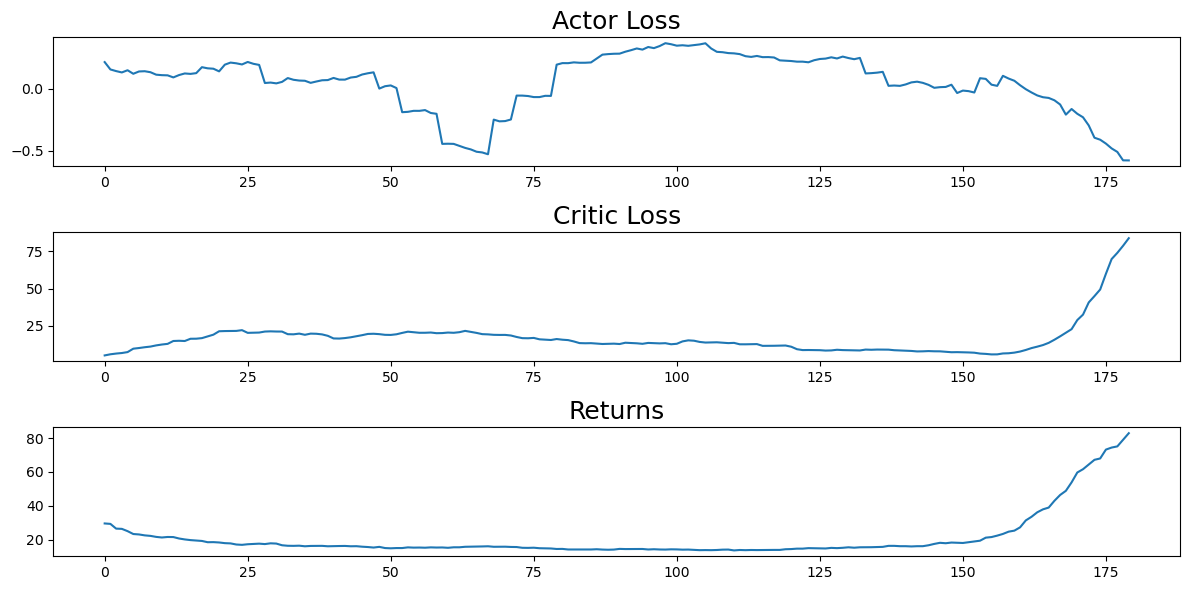

In [25]:
plot_stats(stats)

### Test the resulting agent

/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/Users/isaihbernardo/Documents/college/sideprojects/ML_tetris/Isaih_RL_Notes/OpenAI_Gym/utils.py:247: DeprecationWarning: invalid escape sequence \p
  plt.title("$\pi(s)$", size=16)


TypeError: Image data of dtype object cannot be converted to float

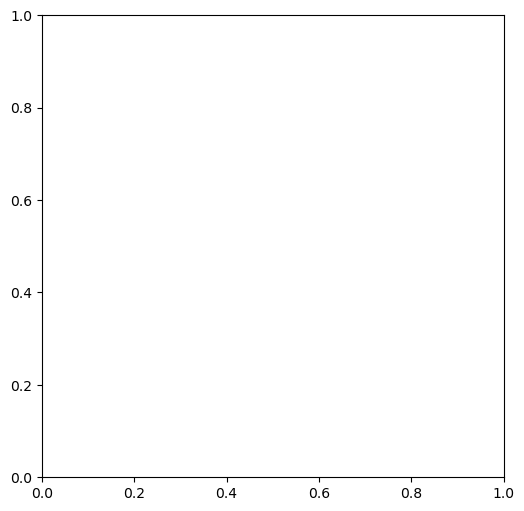

In [26]:
test_policy_network(env, policy, episodes=2)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)